## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
train.shape

(42000, 785)

In [4]:
train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [67]:
test.shape

(28000, 784)

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

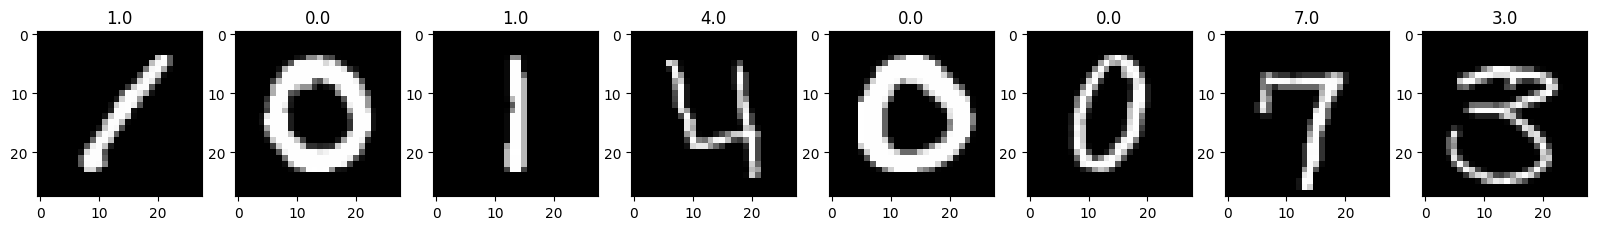

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:8], 1):
    subplot = fig.add_subplot(1, 8, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [8]:
train_img[0].shape

(28, 28)

In [9]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [10]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [11]:
train_sobel_x.shape

(42000, 28, 28)

In [12]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [13]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

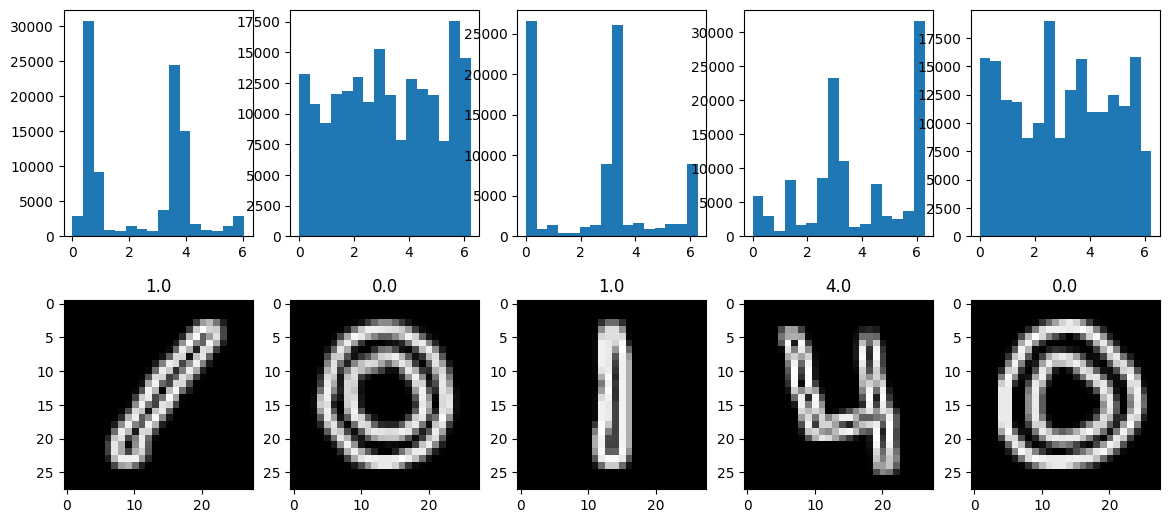

In [14]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [15]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [16]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [17]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [18]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [19]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [56]:
y_pred = rfc.predict(x_val)

In [57]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred))

Accuracy: 0.6452380952380953


In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.40      0.41       816
         1.0       0.97      0.96      0.97       909
         2.0       0.48      0.47      0.47       846
         3.0       0.65      0.69      0.67       937
         4.0       0.71      0.70      0.71       839
         5.0       0.63      0.65      0.64       702
         6.0       0.48      0.47      0.47       785
         7.0       0.86      0.79      0.83       893
         8.0       0.51      0.57      0.54       835
         9.0       0.67      0.69      0.68       838

    accuracy                           0.65      8400
   macro avg       0.64      0.64      0.64      8400
weighted avg       0.65      0.65      0.65      8400



In [59]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[324   5  67  27  36  18 131  12 164  32]
 [  1 874   2   0  21   0   0   5   1   5]
 [ 53   0 396 127   5 103  48  17  82  15]
 [ 23   0  89 648   0  85   9   3  72   8]
 [ 25  12  13   2 590   1  78  30   6  82]
 [ 13   0  83 109   0 456   6   6  26   3]
 [132   1  63  12  64   6 366  16  70  55]
 [  9   4  33   6  48  12  18 707   5  51]
 [132   0  48  45   8  43  44   5 480  30]
 [ 44   1  29  14  55   5  65  18  28 579]]


## Предсказания на тестовых данных

In [60]:
len(test_img)

28000

In [62]:
test_pred = rfc.predict(test_hist)

## Визуализируем предсказания

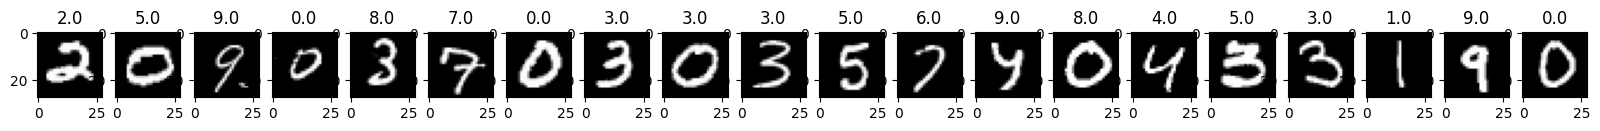

In [72]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(1, 20, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % test_pred[i - 1]);

## Готовим файл для отправки

In [80]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(test_pred, 1):
        if int(p) == 0:
            sec_n = 0
        else:
            sec_n = int(p)
        dst.write('%s,%s\n' % (i, sec_n))